Lab07 - Learning_rate_and_evaluation - Eager execution
 * Learning Rate와 Evaluation에 대한 설명

# 기본 Library 선언 및 Tensorflow 버전 확인

In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D

tf.random.set_seed(777) # from reproducibility
print(tf.__version__)

2.3.1


 * X_data가 3차원 배열이기에 3차원 공간에 표현하여 x1과 x2, x3를 기준으로 y_data 3개 클래스를 구분하는 예제입니다.
 * 해당 Data를 3개의 색상으로 구분해서 출력해보겠습니다.(파랑-2, 초록-1, 빨강-0)

In [32]:
x_train = [[1, 2, 1],
          [1, 3, 2],
          [1, 3, 4],
          [1, 5, 5],
          [1, 7, 5],
          [1, 2, 5],
          [1, 6, 6],
          [1, 7, 7]]

y_train = [[0, 0, 1],
          [0, 0, 1],
          [0, 0, 1],
          [0, 1, 0],
          [0, 1, 0],
          [0, 1, 0],
          [1, 0, 0],
          [1, 0, 0]]

# Evaluation our model using this test dataset
x_test = [[2, 1, 1],
          [3, 1, 2],
          [3, 3, 4]]
y_test = [[0, 0, 1],
          [0, 0, 1],
          [0, 0, 1]]

x1 = [x[0] for x in x_train]
x2 = [x[1] for x in x_train]
x3 = [x[2] for x in x_train]

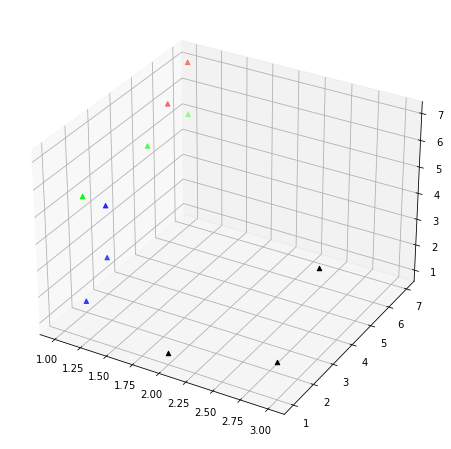

In [33]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(x1,x2,x3,c=y_train,marker='^')

ax.scatter(x_test[0][0], x_test[0][1], x_test[0][2], c='black', marker='^')
ax.scatter(x_test[1][0], x_test[1][1], x_test[1][2], c='black', marker='^')
ax.scatter(x_test[2][0], x_test[2][1], x_test[2][2], c='black', marker='^')

# Tensorflow Eager

위 Data를 기준으로 Learning Rate 값과 평가 모델을 만들도록 하겠습니다.
 * Tensorflow data API를 통해 학습시킬 값들을 담는다. (Batch Size는 한번에 학습시킬 Size로 정한다)
 * Features, Labels는 실제 학습에 쓰일 Data (연산을 위해 Type를 맞춰준다)

In [34]:
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(len(x_train))

위 Data를 기준으로 가설의 검증을 통해 Softmax Classification 모델을 만들도록 하겠습니다.
 * W와 b는 학습을 통해 생성되는 모델에 쓰이는 Weight와 Bias(초기값을 Variable : 0이나 Random 값으로 가능 tf.random_normal([3,3],tf.zeros([3,3]))

In [35]:
W = tf.Variable(tf.random.normal((3,3)))
b = tf.Variable(tf.random.normal((3,)))

Softmax 함수를 가설로 선언합니다.
 * Softmax를 통해 가장 높은 값을 구한다.(0~1 사이의 값 한계는 1)

In [36]:
def softmax_fn(features):
    hypothesis = tf.nn.softmax(tf.matmul(features,W)+b)
    return hypothesis

가설을 검증할 Cost 함수를 정의합니다.
 * Cross Entropy Loss를 사용.

In [37]:
def loss_fn(hypothesis,features,labels):
    cost = tf.reduce_mean(-tf.reduce_sum(labels * tf.math.log(hypothesis),axis=1))
    return cost

Learning Rate 값을 조정하기 위한 Learning Decay 설정

 5개의 파라미터 설정
 * starter_learning_rate : 최초 학습시 사용될 learning rate(0.1로 설정하여 0.96씩 감소하는지 확인)
 * global_step : 현재 학습 횟수
 * 1000 : 곱할 횟수 정의(1000번 마다 적용)
 * 0.96 : 기존 learning에 곱할 값
 * 적용유무 decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)

In [38]:
is_decay = True
starter_learning_rate = 0.1

if(is_decay):
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = starter_learning_rate,
                                                                   decay_steps = 1000,
                                                                   decay_rate = 0.96,
                                                                   staircase = True)
    optimizer = tf.keras.optimizers.SGD(learning_rate)
else:
    optimizer = tf.keras.optimizers.SGD(learning_rate=starter_learning_rate)
    
def grad(hypothesis, features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(softmax_fn(features),features,labels)
    return tape.gradient(loss_value, [W,b])

가설을 통해 실재 값과 비교한 정확도를 측정합니다.

In [39]:
def accuracy_fn(hypothesis, labels):
    prediction = tf.argmax(hypothesis,1)
    is_correct = tf.equal(prediction,tf.argmax(labels,1))
    accuracy = tf.reduce_mean(tf.cast(is_correct,tf.float32))
    return accuracy

Tensorflow를 통해 학습을 진행합니다.
 * 위의 Data를 Cost 함수를 통해 학습시킨 후 모델을 생성합니다.
 * Test Data값 검증 수행 [2,1,1,], [3,1,2], [3,3,4]

In [40]:
epochs = 1001

for step in range(epochs):
    for features,labels in iter(dataset):
        features = tf.cast(features,tf.float32)
        labels = tf.cast(labels,tf.float32)
        grads = grad(softmax_fn(features),features,labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W,b]))
        if step % 100 == 0:
            print("iter: {}, Loss: {:.4f}".format(step,loss_fn(softmax_fn(features),features,labels)))

x_test = tf.cast(x_test,tf.float32)
y_test = tf.cast(y_test,tf.float32)
test_acc = accuracy_fn(softmax_fn(x_test),y_test)
print('Testset Acc: {:.4f}'.format(test_acc))

iter: 0, Loss: 7.8510
iter: 100, Loss: 0.6915
iter: 200, Loss: 0.5892
iter: 300, Loss: 0.5326
iter: 400, Loss: 0.4927
iter: 500, Loss: 0.4615
iter: 600, Loss: 0.4358
iter: 700, Loss: 0.4139
iter: 800, Loss: 0.3951
iter: 900, Loss: 0.3785
iter: 1000, Loss: 0.3638
Testset Acc: 1.0000
